## Data collection

*Document your data collection process and the properties of the data here. Implement, using Python code, to load and preprocess your selected dataset.*

To acquire a large number of Stack Overflow questions regarding C# you can query the official Stack Overflow database with SQL queries at https://data.stackexchange.com/stackoverflow/queries. These queries can only return 50 000 results at a time so multiple queries have to be made to get all the questions from within a specific period of time. The time frame chosen in this report was 2019-09-22 to 2020-11-08. This period of time was chosen since this is the period of time that C# 8 was the current release of C# and the assumption here was that the documentation regarding new features could be the most lacking.

The query used is as follows: <br>
```
SELECT * FROM posts WHERE Tags LIKE '%c#%' AND posts.CreationDate < 'Insert start data here' AND posts.CreationDate > 'Insert end date here'
ORDER BY posts.CreationDate desc
```

Since this operation has to be done in multiple queries the date input will vary but in the end, you will end up with a number of .CSV files containing the data. In our case, we ended up with three files containing 117 527 questions. These files were then combined into one which is the Data.csv file that you can see in the following steps.

### Read the data from the file and output some values to make sure the data read is correct. 

In [77]:
# Importing the necessary libraries
import pandas as pd
from collections import Counter
import textmining as tm
import operator
import os
import nltk
import matplotlib
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
import pyLDAvis
import pyLDAvis.gensim
import matplotlib.pyplot as plt
import seaborn as sns
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import warnings
warnings.simplefilter("ignore", DeprecationWarning)
# Load the LDA model from sk-learn
from sklearn.decomposition import LatentDirichletAllocation as LDA
# Ignore warnings for a specific error that we can ignore in this application
pd.options.mode.chained_assignment = None  # default='warn'

In [78]:
# Read our data from the data.csv file
stackOverflowData = pd.read_csv(
    './Data.csv',
    encoding='utf-8'
)

In [79]:
# Print the size of the dataset read
print('Number of Rows and Columns:')
print(stackOverflowData.shape)

Number of Rows and Columns:
(117527, 23)


In [80]:
# Print the column names of the data
listOfColumnNames = stackOverflowData.columns.values.tolist()
print('Column names:')
for name in listOfColumnNames:
    print(name)

Column names:
Id
PostTypeId
AcceptedAnswerId
ParentId
CreationDate
DeletionDate
Score
ViewCount
Body
OwnerUserId
OwnerDisplayName
LastEditorUserId
LastEditorDisplayName
LastEditDate
LastActivityDate
Title
Tags
AnswerCount
CommentCount
FavoriteCount
ClosedDate
CommunityOwnedDate
ContentLicense


In [81]:
# Print the dates from wich this data is produced
minValue = stackOverflowData['CreationDate'].min()
maxValue = stackOverflowData['CreationDate'].max()
print('Dates from wich the data is produced: ' +
      minValue + ' to ' + maxValue)

Dates from wich the data is produced: 2019-09-22 00:02:14 to 2020-11-08 04:47:27


In [82]:
# Filter the posts that for some reason was closed and those posts that have a negative score.
stackOverflowData = stackOverflowData[stackOverflowData['ClosedDate'].isnull()]
stackOverflowData = stackOverflowData[stackOverflowData['Score']>=0]
stackOverflowData.shape

(98705, 23)

### The next step is to read the data into a Data Frame and prepare the data for the analysis phase

In [83]:
# Creating a Data Frame with only the necessary columns
df = stackOverflowData[['AcceptedAnswerId', 'Title',
                    'CreationDate', 'Body', 'Score']]

In [84]:
# This is not implemented yet but here we will remove all rows witch have an accepted answer
#df = df.loc[df['AcceptedAnswerId'] != '']

In [85]:
# Setting the neccessary data to lowercase 
df['Body'] = df['Body'].str.lower()
df['Title'] = df['Title'].str.lower()

In [86]:
# Creating the stopwords and removing them from the strings in the dataframe.
stop_words = ['the', 'on', 'are', 'is', 'but' 'and', 'in', 'to', 'how', 'for', 'and', 'with', 'can', 'user', 'my', 'it', 'into', 'cannot', 'getting', 'no', 'an', 'a', 'do', 'but', 'one', 'very', 'by', 'from', 'get', 'can', 'of', 'not', 'using', 'does', 'why', 'as', 'use', 'or', 'one', 'two', 'this', 'be', 'make', 'at', 'up', 'being', 'after', 'when', 'through', 'any', 'first', 'open', 'what', 'same', 'trying', 'what', 'than', 'another', 'way', 'check', 'there', 'without', 'other', 'which']
df['Title'] = df['Title'].apply(lambda x: ' '.join(
    [word for word in x.split() if word not in (stop_words)]))
df['Body'] = df['Body'].apply(lambda x: ' '.join(
    [word for word in x.split() if word not in (stop_words)]))

In [87]:
# Tokenize the words in Title and create a list datalist containing all the Titles.
title_list = df.Title.values.tolist()

def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

title_words = list(sent_to_words(title_list))

In [88]:
#creat dict
# Create Dictionary
title_dictionary = corpora.Dictionary(title_words)

# Create Corpus
texts = title_words

# Term Document Frequency
corpus = [title_dictionary.doc2bow(text) for text in texts]

In [89]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(title_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[title_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[title_words[1]]])

['object', 'reference', 'set', 'instance', 'object', 'referencing', 'custom', 'class', 'made', 'controller']


In [90]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=title_dictionary,
                                           num_topics=15, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [91]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, title_dictionary)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
11     0.406686  0.198342       1        1  13.328955
7      0.129405 -0.401243       2        1  10.407232
4      0.085651 -0.110544       3        1   8.589125
8     -0.020772  0.015438       4        1   7.473588
1     -0.007104  0.008392       5        1   7.323364
13    -0.022873  0.016647       6        1   7.145448
3     -0.028870  0.019136       7        1   6.682759
9     -0.042946  0.024892       8        1   6.302226
10    -0.042241  0.024519       9        1   5.976678
14    -0.058398  0.029923      10        1   5.725584
2     -0.055381  0.029205      11        1   5.513561
0     -0.083812  0.036187      12        1   4.307984
12    -0.076411  0.034783      13        1   3.934048
5     -0.091092  0.037130      14        1   3.646307
6     -0.091842  0.037193      15        1   3.643143, topic_info=          Term          Freq         Total Category  logprob  loglift
114        net  20508.000000  20508.000000  Default  30.0000  30.0000
111        asp  10730.000000  10730.000000  Default  29.0000  29.0000
112       core  13911.000000  13911.000000  Default  28.0000  28.0000
170       data   7802.000000   7802.000000  Default  27.0000  27.0000
158       file   7782.000000   7782.000000  Default  26.0000  26.0000
...        ...           ...           ...      ...      ...      ...
81       cross      0.106562      1.583799  Topic15 -12.2918   0.6135
807   gridview      0.108458      1.614350  Topic15 -12.2741   0.6120
1626  retrieve      0.108232      1.611734  Topic15 -12.2762   0.6115
558       rows      0.108435      1.618343  Topic15 -12.2743   0.6093
1404      need      0.108436      1.658479  Topic15 -12.2743   0.5848

[511 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
337       9  0.999530   access
797       1  0.998306   action
1793      6  0.995628       ad
17        9  0.999628      add
297       9  0.998620   adding
...     ...       ...      ...
437      11  0.998394    write
93        5  0.999599  xamarin
956       4  0.998095     xaml
16        3  0.999675      xml
638       2  0.998471      you

[419 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[12, 8, 5, 9, 2, 14, 4, 10, 11, 15, 3, 1, 13, 6, 7])

In [92]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=title_words, dictionary=title_dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -14.085414500460601

Coherence Score:  0.2610871642214686


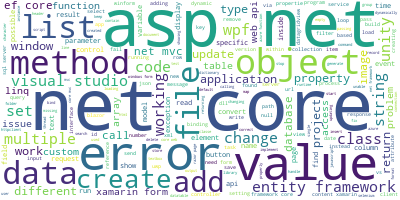

In [93]:
# Import the wordcloud library
from wordcloud import WordCloud
# Join the different processed titles together.
long_string = ','.join(list(df['Title'].values))
# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')
# Generate a word cloud
wordcloud.generate(long_string)
# Visualize the word cloud
wordcloud.to_image()

C:\Users\AxelS\miniconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


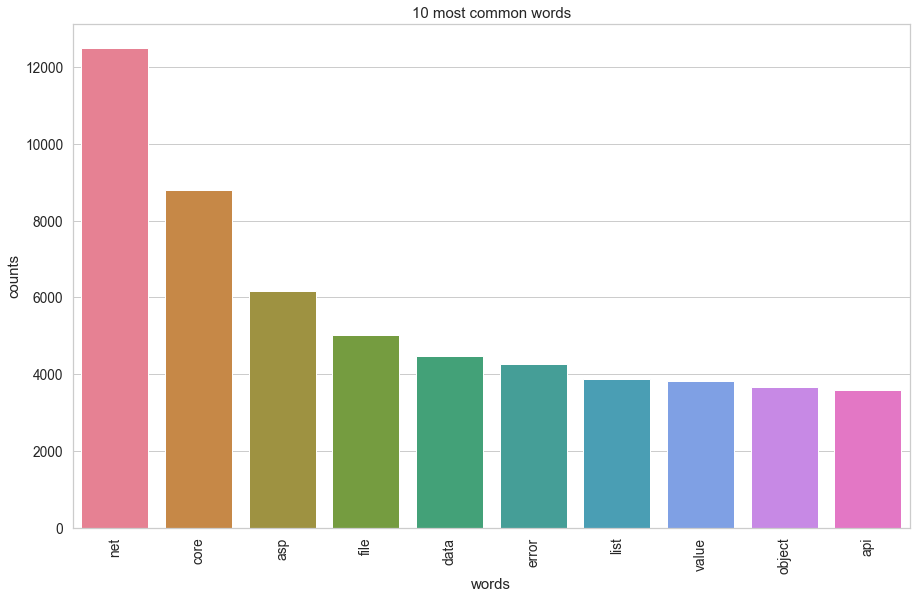

In [94]:
sns.set_style('whitegrid')
%matplotlib inline

# Helper function
def plot_10_most_common_words(count_data, count_vectorizer):
    import matplotlib.pyplot as plt
    words = count_vectorizer.get_feature_names()
    total_counts = np.zeros(len(words))
    for t in count_data:
        total_counts+=t.toarray()[0]
    
    count_dict = (zip(words, total_counts))
    count_dict = sorted(count_dict, key=lambda x:x[1], reverse=True)[0:10]
    words = [w[0] for w in count_dict]
    counts = [w[1] for w in count_dict]
    x_pos = np.arange(len(words)) 
    
    plt.figure(2, figsize=(15, 15/1.6180))
    plt.subplot(title='10 most common words')
    sns.set_context("notebook", font_scale=1.25, rc={"lines.linewidth": 2.5})
    sns.barplot(x_pos, counts, palette='husl')
    plt.xticks(x_pos, words, rotation=90) 
    plt.xlabel('words')
    plt.ylabel('counts')
    plt.show()

# Initialise the count vectorizer with the English stop words
count_vectorizer = CountVectorizer(stop_words='english')

# Fit and transform the processed titles
count_data = count_vectorizer.fit_transform(df['Title'])

# Visualise the 10 most common words
plot_10_most_common_words(count_data, count_vectorizer)

In [95]:
# Helper function
def print_topics(model, count_vectorizer, n_top_words):
    words = count_vectorizer.get_feature_names()
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #%d:" % topic_idx)
        print(" ".join([words[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
        
# Tweak the two parameters below (use int values below 15)
number_topics = 20
number_words = 10

# Create and fit the LDA model
lda = LDA(n_components=number_topics)
lda.fit(count_data)

# Print the topics found by the LDA model
print("Topics found via LDA:")
print_topics(lda, count_vectorizer, number_words)

Topics found via LDA:

Topic #0:
object type generic form method class message instance reference bot

Topic #1:
visual studio time code project vs dll 2019 error build

Topic #2:
azure function expression type error lambda storage functions object cast

Topic #3:
xamarin wpf forms binding page work nuget package control xaml

Topic #4:
list linq sql query objects values column table data multiple

Topic #5:
text change item selected combobox save button color wpf value

Topic #6:
value null property parameter variable ef event attribute set method

Topic #7:
string json array file convert xml excel read format text

Topic #8:
loop stored position procedure foreach object mouse working camera isn

Topic #9:
different image task async wpf await date timer false true

Topic #10:
data view model controller html page mvc razor form action

Topic #11:
unity blazor script need component input game library work 2d

Topic #12:
net core asp api mvc web authentication identity application token


In [96]:
def display_topics(model, feature_names, no_top_words):
    topic_dict = {}
    for topic_idx, topic in enumerate(model.components_):
        topic_dict["Topic %d words" % (topic_idx)]= ['{}'.format(feature_names[i])
                        for i in topic.argsort()[:-no_top_words - 1:-1]]
    return pd.DataFrame(topic_dict)

topicdf = display_topics(lda, count_vectorizer.get_feature_names(), 10)
topicdf

,Topic 0 words,Topic 1 words,Topic 2 words,Topic 3 words,Topic 4 words,Topic 5 words,Topic 6 words,Topic 7 words,Topic 8 words,Topic 9 words,Topic 10 words,Topic 11 words,Topic 12 words,Topic 13 words,Topic 14 words,Topic 15 words,Topic 16 words,Topic 17 words,Topic 18 words,Topic 19 words
0,object,visual,azure,xamarin,list,text,value,string,loop,different,data,unity,net,application,error,key,framework,method,file,service
1,type,studio,function,wpf,linq,change,null,json,stored,image,view,blazor,core,app,connection,element,entity,request,class,test
2,generic,time,expression,forms,sql,item,property,array,position,task,model,script,asp,console,server,selenium,database,api,load,windows
3,form,code,type,binding,query,selected,parameter,file,procedure,async,controller,need,api,windows,email,datagridview,core,client,access,process
4,method,project,error,page,objects,combobox,variable,convert,foreach,wpf,html,component,mvc,android,send,regex,update,exception,files,run
5,class,vs,lambda,work,values,save,ef,xml,object,await,page,input,web,xamarin,invalid,ienumerable,data,http,path,running
6,message,dll,storage,nuget,column,button,event,excel,mouse,date,mvc,game,authentication,uwp,output,node,table,response,assembly,unit
7,instance,2019,functions,package,table,color,attribute,read,working,timer,razor,library,identity,config,failed,tag,delete,post,microsoft,dependency
8,reference,error,object,control,data,wpf,set,format,camera,false,form,work,application,log,mongodb,item,dbcontext,error,pdf,start
9,bot,build,cast,xaml,multiple,value,method,text,isn,true,action,2d,token,print,certificate,match,key,httpclient,automapper,injection


In [97]:
arraydata = lda.transform(count_data)

In [98]:
def get_topic(topic_scores):
    maxscore = 0
    topicNbr = 0
    fittingTopic = 0
    for score in topic_scores:
        current_score = score
        if current_score>maxscore:
            maxscore = current_score
            fittingTopic = topicNbr
        topicNbr += 1
    return fittingTopic

In [99]:
def topic_list():
    the_list = []
    for scoreList in arraydata:
        the_list.append(get_topic(scoreList))
    return the_list


In [100]:
df.insert(5, "Topic", topic_list(), True) # if Topic is not implemented

In [102]:
df.head(20)

,AcceptedAnswerId,Title,CreationDate,Body,Score,Topic
0,NaN,return value class that inherits marshalbyrefo...,2020-11-08 04:47:27,<p>i load / unload assembly all types then cre...,0,0
1,NaN,"""nullreferenceexception: object reference set ...",2020-11-08 04:45:51,<p>i figure out isnt set life me. anyone spot ...,0,0
2,NaN,parentnode childnodes xml linq,2020-11-08 04:39:23,"<p>i need following data</p> <p><a href=""https...",0,15
3,NaN,i add menuitem option context menu editor clas...,2020-11-08 04:35:45,<pre><code>using system; system.collections.ge...,0,5
4,NaN,wpf c# add text image combobox during runtime,2020-11-08 04:24:53,"<p>basically, clicks button i would like add l...",0,5
5,64734851.0,properly while loop null int values input c#,2020-11-08 04:23:15,<p>i am basically continue loop until enters r...,0,6
6,NaN,show all ip input table sql server ( c#),2020-11-08 04:20:42,"<p>i am show all ip computer, if ip starts wit...",0,4
7,NaN,styling windows form tab,2020-11-08 04:13:45,<p>i am creating windows tabbed application. e...,0,3
8,NaN,c# precision small numbers,2020-11-08 04:09:07,<p>i'm programming algorithm dealing many smal...,0,7
9,NaN,"i changed size form winform, size form still f...",2020-11-08 04:07:32,"<p>the display design interface normal, short ...",0,9


In [41]:
whiteList = pd.read_csv(
    './csharp-topics.csv',
    encoding='utf-8')
mydict = {}
whiteList['C# documentation'] = whiteList['C# documentation'].str.lower()
for topic in whiteList['C# documentation']:
    mydict[topic] = df['Title'].str.contains(topic, regex=False).sum()

In [40]:
mydict

{'readonly member': 4,
 'default interface method': 5,
 'pattern matching enhancement': 1,
 'switch expression': 35,
 'tuple pattern': 0,
 'property pattern': 0,
 'positional pattern': 1,
 'using declaration': 3,
 'disposable ref struct': 0,
 'static local function': 2,
 'nullable reference type': 46,
 'asynchronous stream': 1,
 'asynchronous disposable': 0,
 'indice and range': 0,
 'null-coalescing assignment': 2,
 'unmanaged constructed': 0,
 'interpolated verbatim string': 1,
 'stackalloc nested expression': 0}

<AxesSubplot:>

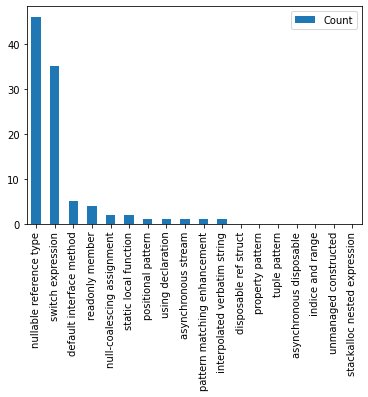

In [16]:
dataframe = pd.DataFrame.from_dict(mydict, orient = 'index', columns=['Count'])
dataframe = dataframe.sort_values(by=['Count'], ascending = False)
dataframe.head(30).plot.bar()

## Data analysis

*Document you choice and motivation for selected data mining method(s) here. Choose a data mining method(s) to use in Python code to perform an analysis of your chosen dataset. Describe why you chose the method(s) and what interesting things you have found from the analysis.*

*Replace the contents of this cell with your own text.*

In [ ]:
# Create a list of the top appearing words. The nrOfWords variable defines how many words the list should contain.
nrOfWords = 10
rslt = Counter(' '.join(df['Body']).split()).most_common(nrOfWords)

# Print out the list created above.
print('\n')
for word in rslt:
    print('{} = {}'.format(word[1], word[0]))

## Evaluation of results

*Document an evaluation your analysis results and describe how potentially actionable they are.*

*Replace the contents of this cell with your own text.*

In [ ]:
# Add your own code

## Schedule and description of project plan

*Rough schedule for the project beyond the pilot study presented in 3-5. This does not have to be advanced, you can simply provide an estimate based upon reported schedules for similar projects in the literature.*

*Replace the contents of this cell with your own text.*

## Ethical aspects that need to be considered

*Are there ethical aspects that need to be considered? Are there legal implications (e.g., personal data / GDPR)? Are there implications if the case organization is a business, public authority, or nonprofit entity?*

*Replace the contents of this cell with your own text.*